In [1]:
import os
import gc
import glob
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        root_list = glob.glob(root_dir)
        self.transform = transform

        self.data = []
        for path in tqdm(root_list):
#             class_name = img_path.split(os.sep)[-2]
            self.data.append(path)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.data[idx]
        array = np.load(path, allow_pickle = True)
        img = array[0]
        mass = torch.tensor(-(math.log10(array[1])))
       
        if self.transform:
            aug = self.transform(image = img)
            img = aug['image']
        
        img = img.to(torch.float)        

        return img, mass

In [3]:
transforms = A.Compose(
            [
                A.CenterCrop(height = 50, width = 50, p=1.0),
                ToTensorV2()
            ]
        )

In [4]:
BS = 128

In [5]:
data_path = r'../input/gsocml4scimodel2/Model_II/axion/*'
dataset = CustomDataset(data_path, transform = transforms)
len(dataset)

  0%|          | 0/29896 [00:00<?, ?it/s]

29896

In [6]:
m = len(dataset)
test_split_size = 0.1

print("Total training data: " + str(m))

try:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size)])
except:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size+1)])
    
len(train_set), len(val_set)

Total training data: 29896


(26906, 2990)

In [7]:
test_data_path = r'../input/gsocml4scimodel2test/Model_II_test/axion/*'
test_set = CustomDataset(test_data_path, transform = transforms)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
len(train_set), len(val_set), len(test_set)

(26906, 2990, 5000)

In [9]:
train_loader = DataLoader(train_set, batch_size = BS, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BS, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BS, shuffle = False)

In [10]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([128, 1, 50, 50])

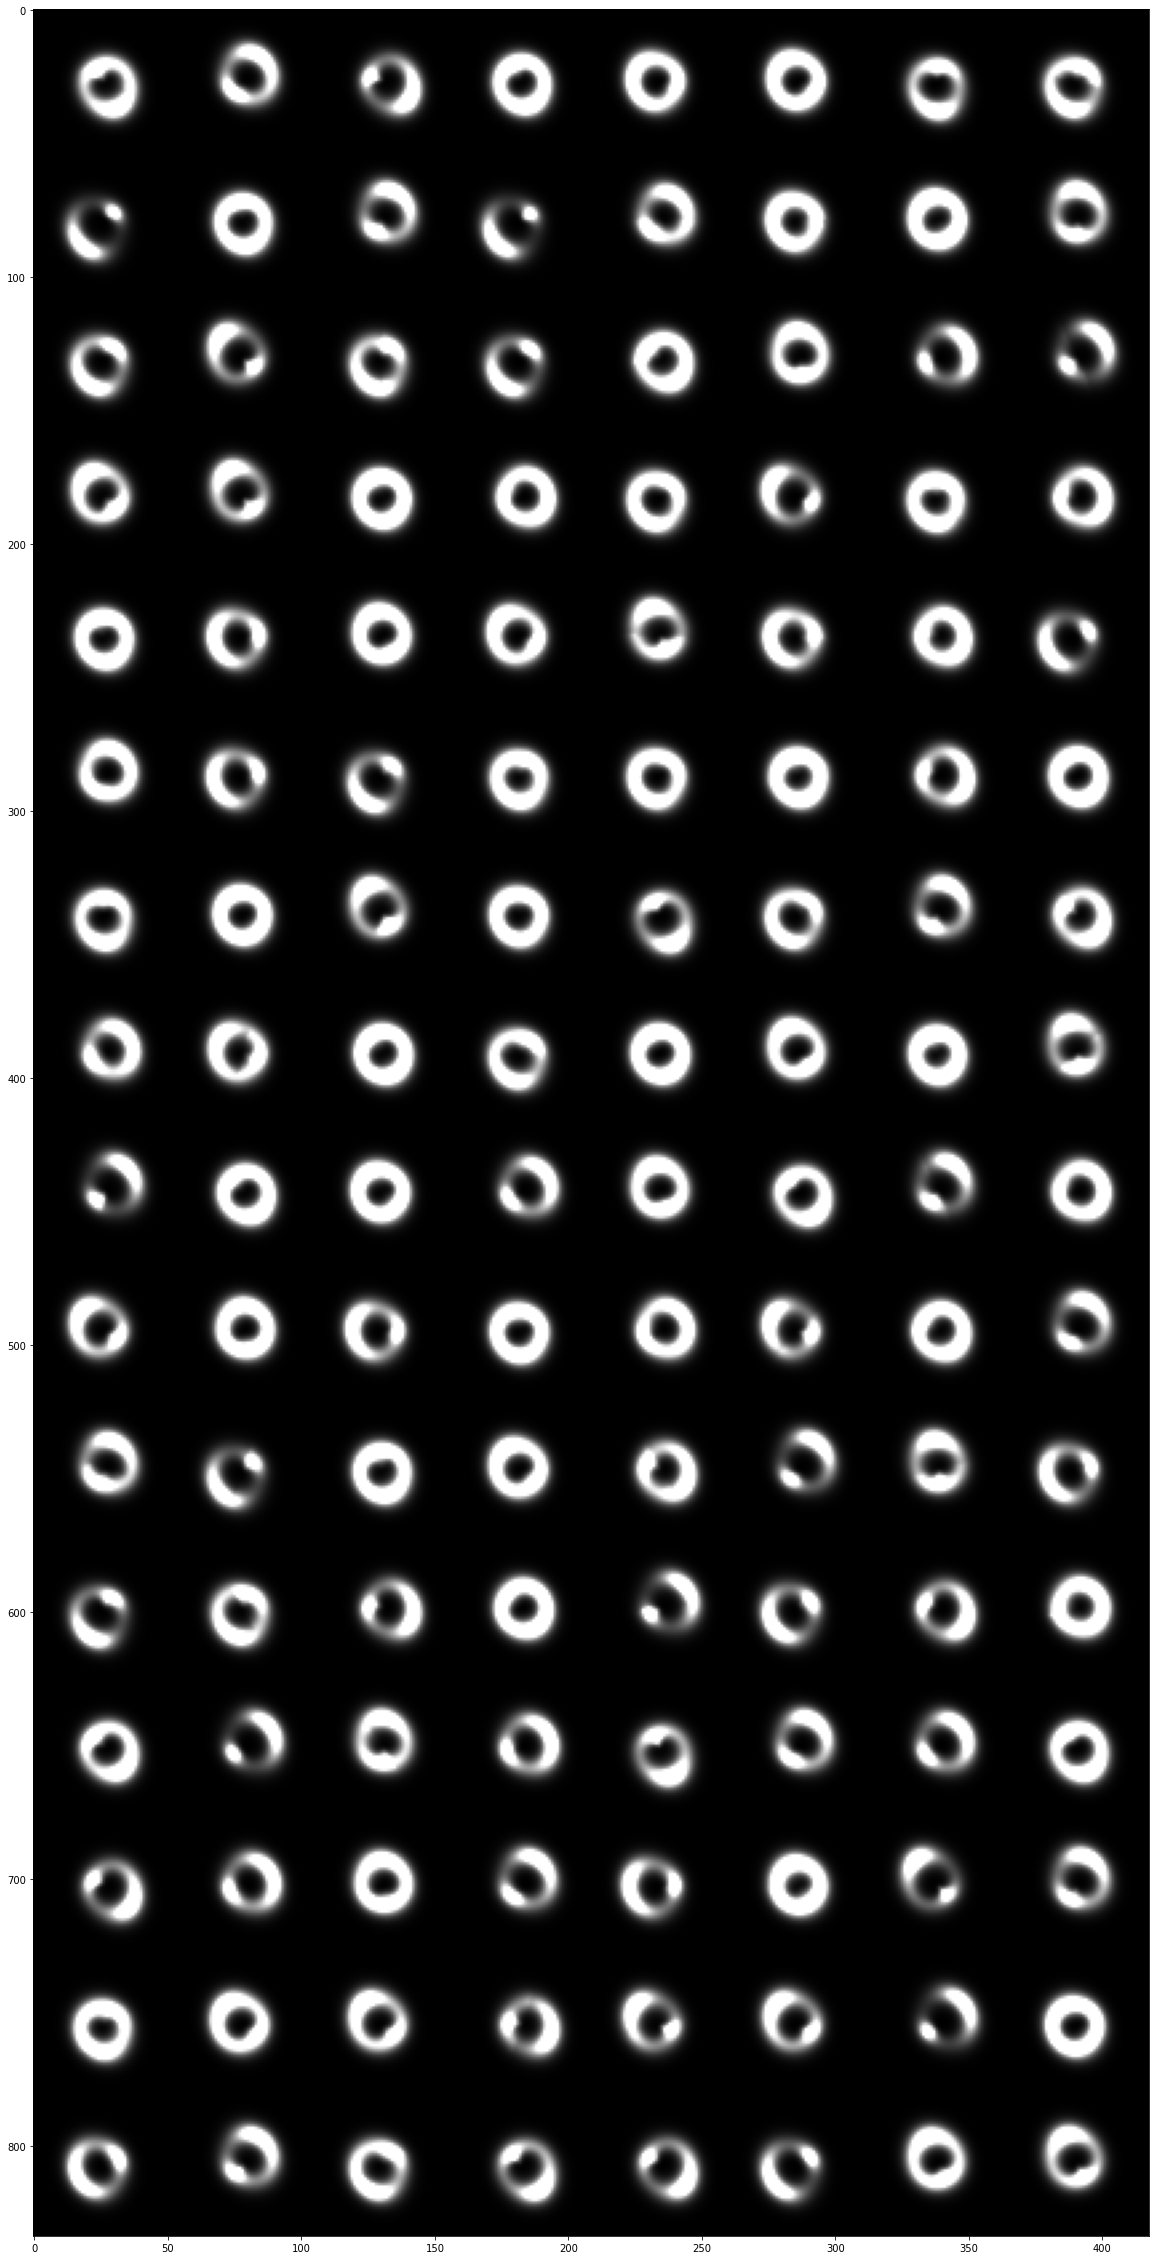

In [11]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [12]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b1',pretrained = pretrained, in_chans = 1)
#         num_in_features = self.model.get_classifier().in_features
        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1280 * 2 * 2, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(1024, 512),
                                nn.BatchNorm1d(512),
                                nn.PReLU(),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(512, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.3),
                                
                                nn.Linear(128, 1)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1280 * 2 * 2)
        x = self.fc(x)
        return x

In [13]:
model = pre_trained_model()

x = torch.randn(128, 1, 50, 50)
print(model(x).shape)

del model
gc.collect()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


torch.Size([128, 1])


8

In [14]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
        y_pred = y_pred.view(-1)
        #loss calculation
        loss = criterion(y_pred, y_truth)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return model, np.mean(train_loss)

In [15]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)
            y_pred = y_pred.view(-1)

            #loss calculation
            loss = criterion(y_pred, y_truth)

            #batch loss
            val_loss.append(loss.detach().cpu().numpy())
            
    return np.mean(val_loss)

In [16]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss = val_epoch(model, val_loader, criterion)

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)


    return model, loss_dict

In [17]:
model = pre_trained_model().to(device)

criterion = nn.MSELoss()
EPOCHS = 20
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

In [18]:
#Training model
model, loss_dict = fit_model(model,criterion,optimizer)

Epoch 1/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:516.0447387695312, Val loss:497.2620544433594
Epoch 2/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:452.212890625, Val loss:394.0452880859375
Epoch 3/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:316.2538146972656, Val loss:240.9707794189453
Epoch 4/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:166.5620574951172, Val loss:97.88214111328125
Epoch 5/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:65.8075942993164, Val loss:44.73945236206055
Epoch 6/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:22.920175552368164, Val loss:5.855210781097412
Epoch 7/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:12.233171463012695, Val loss:1.2814968824386597
Epoch 8/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:10.427639961242676, Val loss:0.7065148949623108
Epoch 9/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:10.462326049804688, Val loss:2.1035945415496826
Epoch 10/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:9.907955169677734, Val loss:0.4837704002857208
Epoch 11/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:9.139717102050781, Val loss:3.243572473526001
Epoch 12/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:9.11600399017334, Val loss:0.3789924085140228
Epoch 13/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:9.834091186523438, Val loss:0.3724088668823242
Epoch 14/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:8.702786445617676, Val loss:0.40914425253868103
Epoch 15/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:8.951248168945312, Val loss:0.3585834205150604
Epoch 16/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:8.69727611541748, Val loss:0.5423155426979065
Epoch 17/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:8.9580078125, Val loss:1.2880932092666626
Epoch 18/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:8.933523178100586, Val loss:0.47932353615760803
Epoch 19/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:7.909726619720459, Val loss:0.3835794925689697
Epoch 20/20:


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss:7.305677890777588, Val loss:0.45157110691070557


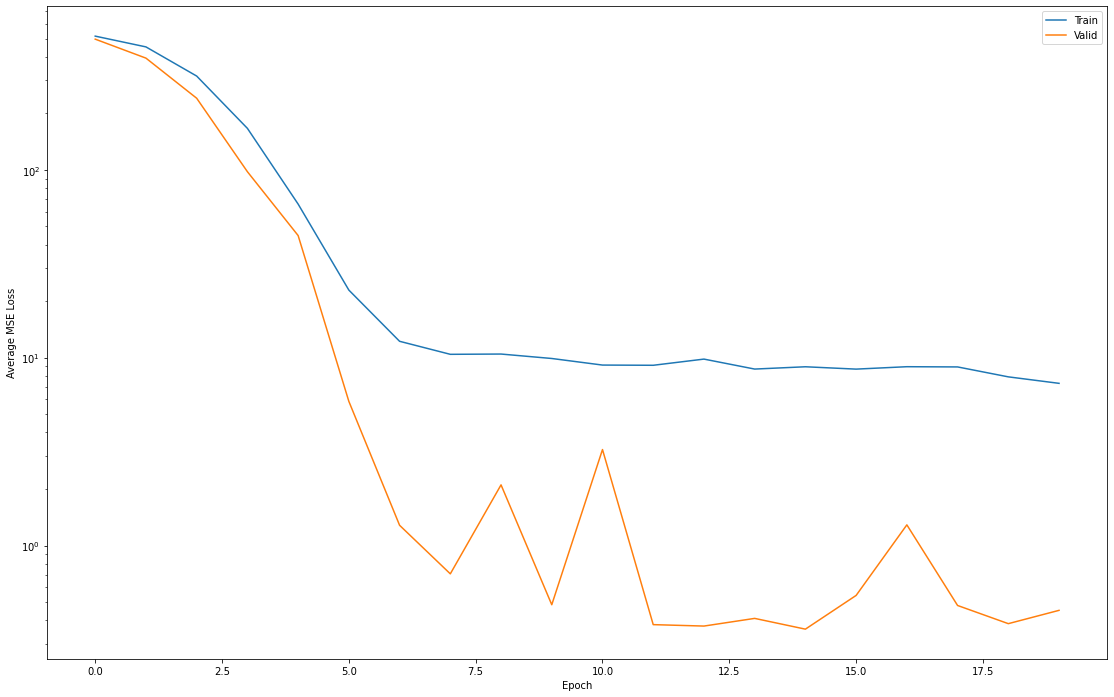

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot losses
plt.figure(figsize=(19,12))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()
plt.savefig("Loss_history.png")

In [20]:
PATH = "effnetB1_reg.pth"
torch.save(model.state_dict(), PATH)

In [21]:
del model
gc.collect()

model = pre_trained_model().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
print("Train set MSE:", end = '')
print(val_epoch(model, train_loader, criterion))

print("Val set MSE:", end = '')
print(val_epoch(model, val_loader, criterion))

print("Test set MSE:", end = '')
print(val_epoch(model, test_loader, criterion))

Train set MSE:

  0%|          | 0/211 [00:00<?, ?it/s]

0.48389396
Val set MSE:

  0%|          | 0/24 [00:00<?, ?it/s]

0.4515711
Test set MSE:

  0%|          | 0/40 [00:00<?, ?it/s]

0.41531906
